In [1]:
%matplotlib widget
import os  
import sys  
sys.path.insert(0, os.getenv('HOME')+'/pycode/MscThesis/')
from amftrack.pipeline.functions.post_processing.extract_study_zone import *
import pandas as pd
import ast
from amftrack.plotutil import plot_t_tp1
from scipy import sparse
from datetime import datetime
import pickle
import scipy.io as sio
from pymatreader import read_mat
from matplotlib import colors
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage import filters
from random import choice
import scipy.sparse
import os
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.paths.directory import run_parallel, find_state, directory_scratch, directory_project
from amftrack.notebooks.analysis.util import * 
from scipy import stats
from scipy.ndimage.filters import uniform_filter1d
from collections import Counter
from IPython.display import clear_output
from amftrack.notebooks.analysis.data_info import *
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams.update({
    "font.family": "verdana",
'font.weight' : 'normal',
'font.size': 20})
from amftrack.plotutil import plot_node_skel
from amftrack.notebooks.validation.util import *
from amftrack.pipeline.paths.directory import *
from amftrack.util import *
import pickle
from amftrack.pipeline.functions.post_processing.extract_study_zone import load_study_zone
from amftrack.pipeline.functions.post_processing.time_hypha import *
from amftrack.pipeline.functions.image_processing.experiment_class_surf import Experiment, save_graphs, load_graphs, load_skel
from amftrack.pipeline.functions.image_processing.experiment_class_surf import Edge

from shapely.geometry import Polygon, shape,Point
from scipy import spatial

/home/cbisot/pycode/MscThesis/amftrack/transfer/functions/transfer.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
directory = directory_project
# update_analysis_info(directory)
analysis_info = get_analysis_info(directory)

In [22]:
select = analysis_info 
num = 13
rows = [row for (index, row) in select.iterrows()]
for index,row in enumerate(rows):
    path = f'{directory}{row["folder_analysis"]}'
    print(index,row["Plate"])
    try:
        a = np.load(f'{path}/center.npy')
    except:
        print(index,row["Plate"])
    if index == num:
        path_exp = f'{directory}{row["path_exp"]}'
        exp = pickle.load(open(path_exp, "rb"))
        exp.dates.sort()
        break

0 799
1 790
2 792
3 800
4 22
4 22
5 80
6 10
7 76
8 102
9 94
10 88
11 26
12 808
13 152


In [23]:
load_study_zone(exp)
load_graphs(exp,labeled=True,indexes = [0])

In [24]:
def get_hulls(exp,ts):
    hulls = []
    for t in ts:
        nx_graph = exp.nx_graph[t]
        threshold = 0.1
        S = [nx_graph.subgraph(c).copy() for c in nx.connected_components(nx_graph)]
        selected = [
            g for g in S if g.size(weight="weight") * len(g.nodes) / 10 ** 6 >= threshold
        ]
        if len(selected)>=0:
            area_max = 0
            for g in selected:
                nodes = np.array([node.pos(t) for node in exp.nodes if node.is_in(t) and np.all(is_in_study_zone(node,t,1000,150)) and (node.label in g.nodes)])
                if len(nodes)>3:
                    hull=spatial.ConvexHull(nodes)
                    poly = Polygon([nodes[vertice] for vertice in hull.vertices])
                    area_hull = poly.area* 1.725**2/(1000**2)
                    if area_hull>=area_max:
                        area_max=area_hull
                        select_poly  = poly
        else:
            select_poly = Polygon()
        hulls.append(select_poly)
    return(hulls)
                


In [7]:
def ring_area(hull1,hull2):
    return(hull2.area* 1.725**2/(1000**2)-hull1.area* 1.725**2/(1000**2))

In [29]:
def get_nodes_in_ring(hull1,hull2,t):
    nodes = [node for node in exp.nodes if node.is_in(t) and hull2.contains(Point(node.pos(t))) and not hull1.contains(Point(node.pos(t))) and np.all(is_in_study_zone(node,t,1000,150))]
    return(nodes)

In [9]:
def get_length_in_ring(hull1,hull2,t):
    nodes = get_nodes_in_ring(hull1,hull2,t)
    edges = {edge for node in nodes for edge in node.edges(t)}
    tot_length = np.sum([np.linalg.norm(edge.end.pos(t)-edge.begin.pos(t))*1.725 for edge in edges])
    return(tot_length)


In [10]:
hulls = get_hulls(exp,range(exp.ts))

In [20]:
areas = [hull.area* 1.725**2/(1000**2) for hull in hulls]
area_incr = areas[-1]-areas[0]
incr = area_incr /num
regular_hulls = [hulls[0]]
init_area = areas[0]
indexes = [0]
current_length = incr
current_area = init_area
for i in range(num-1):
    current_area += incr
    index = min([i for i in range(len(areas)) if areas[i]>=current_area])
    indexes.append(index)
    regular_hulls.append(hulls[index])
    print(current_area,index)

281.6709753206251 32
500.3700753093751 45
719.0691752981252 45
937.7682752868752 45
1156.4673752756253 51
1375.1664752643753 59
1593.8655752531254 65
1812.5646752418754 68
2031.2637752306255 70


In [12]:
def get_regular_hulls(num,exp,ts):
    hulls = get_hulls(exp,ts)
    areas = [hull.area* 1.725**2/(1000**2) for hull in hulls]
    area_incr = areas[-1]-areas[0]
    length_incr = np.sqrt(area_incr)
    incr = length_incr /num
    regular_hulls = [hulls[0]]
    init_area = areas[0]
    indexes = [0]
    current_length = incr
    for i in range(num-1):
        current_area = init_area + current_length**2
        index = min([i for i in range(len(areas)) if areas[i]>=current_area])
        indexes.append(index)
        current_length += incr
        regular_hulls.append(hulls[index])
    return(regular_hulls,indexes)

In [13]:
def get_regular_hulls_area(num,exp,ts):
    hulls = get_hulls(exp,ts)
    areas = [hull.area* 1.725**2/(1000**2) for hull in hulls]
    area_incr = areas[-1]-areas[0]
    incr = area_incr /num
    regular_hulls = [hulls[0]]
    init_area = areas[0]
    indexes = [0]
    current_length = incr
    current_area = init_area
    for i in range(num-1):
        current_area += incr
        index = min([i for i in range(len(areas)) if areas[i]>=current_area])
        indexes.append(index)
        regular_hulls.append(hulls[index])
    return(regular_hulls,indexes)

In [35]:
import imageio
imageio.mimsave()

In [25]:
num = 10
ts = range(exp.ts)
regular_hulls1,indexes1 = get_regular_hulls(num,exp,ts)
regular_hulls2,indexes2 = get_regular_hulls_area(num,exp,ts)
indexes1,indexes2

([0, 8, 11, 15, 18, 22, 26, 30, 33, 37],
 [0, 15, 20, 24, 27, 30, 32, 35, 37, 39])

In [26]:
[ring_area(regular_hulls2[i],regular_hulls2[i+1]) for i in range(len(regular_hulls2)-1)]

[246.89405889281252,
 250.15976715937506,
 261.91800588374997,
 225.42207238125002,
 272.5818052696876,
 229.58761708687507,
 275.4477695615626,
 205.44746500406222,
 230.7589912096878]

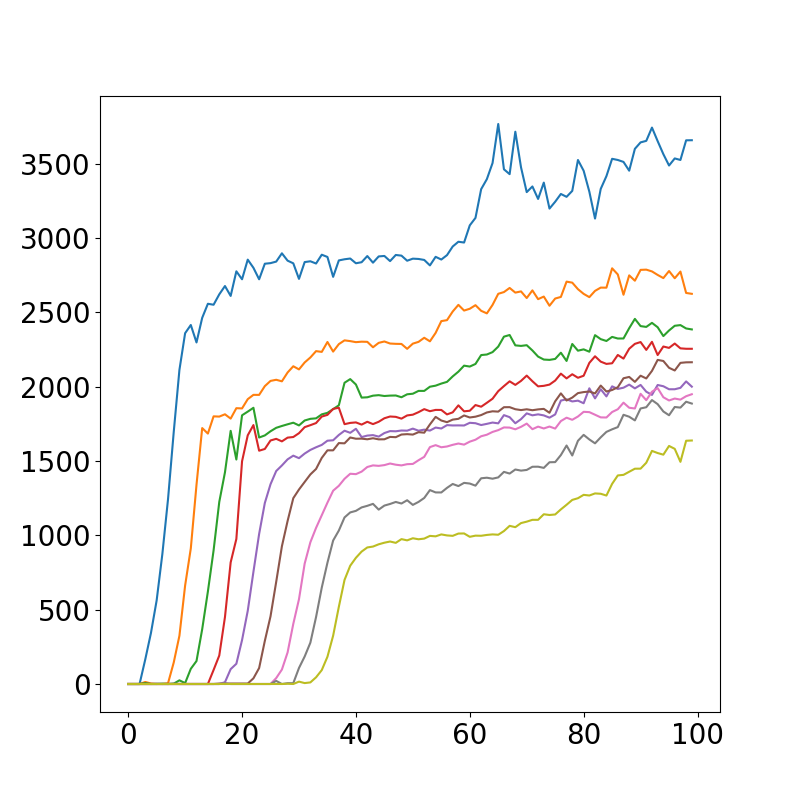

In [27]:
fig=plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
for i in range(len(regular_hulls1)-1):
    hull1,hull2 = regular_hulls1[i],regular_hulls1[i+1]
    lengths = [get_length_in_ring(hull1,hull2,t) for t in range(exp.ts)]
    area= ring_area(hull1,hull2)
    ax.plot(range(exp.ts),np.array(lengths)/area)

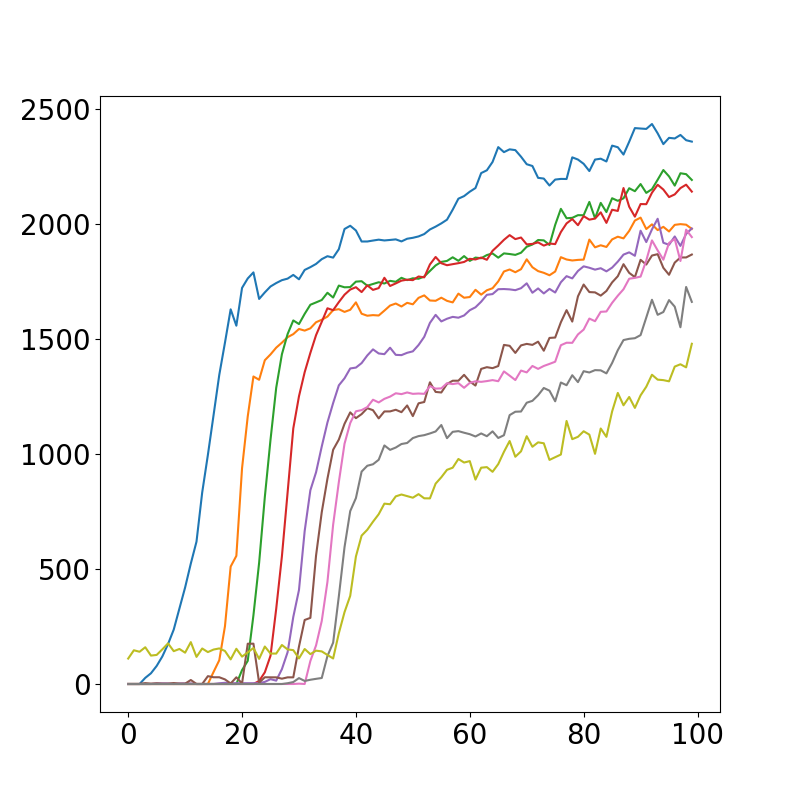

In [28]:
fig=plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
for i in range(len(regular_hulls2)-1):
    hull1,hull2 = regular_hulls2[i],regular_hulls2[i+1]
    lengths = [get_length_in_ring(hull1,hull2,t) for t in range(exp.ts)]
    area= ring_area(hull1,hull2)
    ax.plot(range(exp.ts),np.array(lengths)/area)

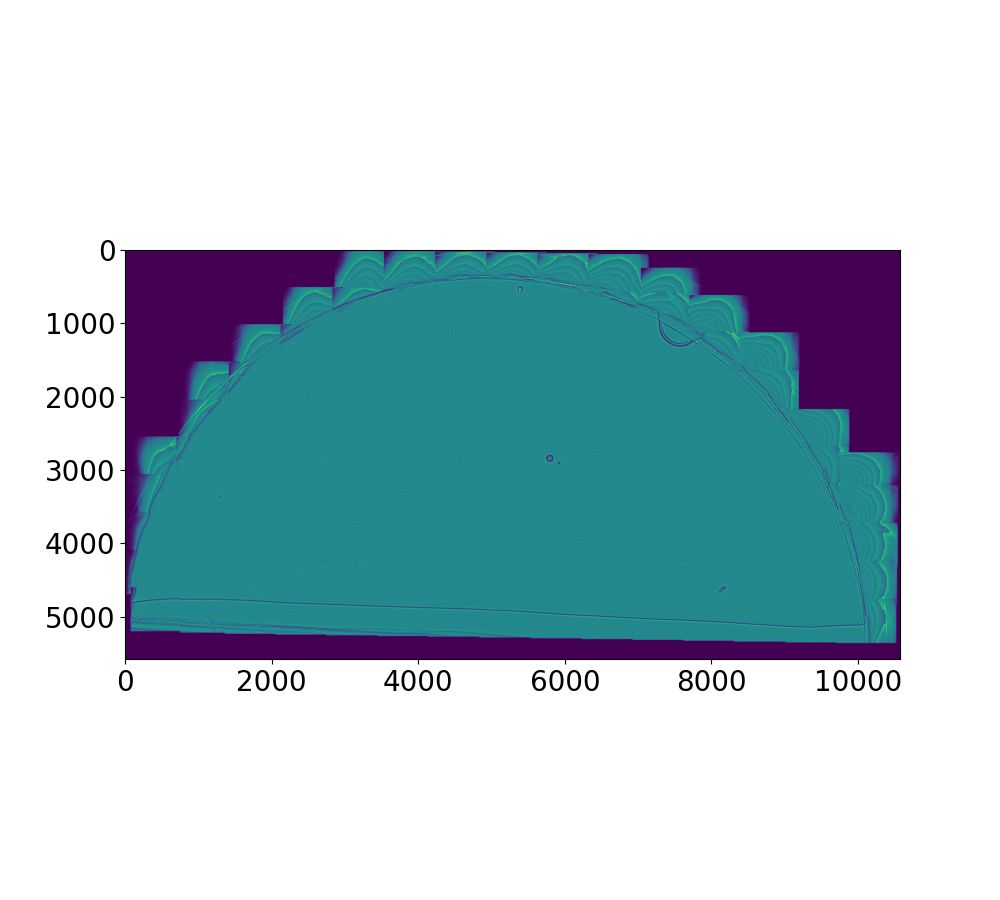

In [34]:
exp.plot_raw(50)

In [ ]:
lengths = [get_length_in_ring(hull1,hull2,t) for t in range(exp.ts)]
area= ring_area(hull1,hull2)